In [1]:
from mss import mss
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from PIL import Image
from time import sleep
from keyboard import is_pressed # To stop certain iterations
from time import sleep
import winsound # To know when it's already running
from thalamus import Thalamus
from limbicus2 import ResidualBlock, LimbicSystemA, LimbicSystemB, LimbicSystemC
from human_teacher import save_chunk

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

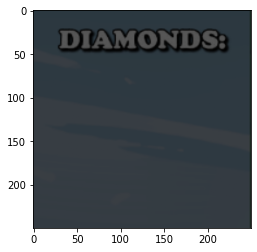

In [20]:
# Testing to check regions coordinates

# life_bombs = (750, 1700, 1900-1700, 990-750)
# score = (180, 0, 240, 60)
# diamonds = (800, 0, 250, 250)

sleep(2)

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

with mss() as sct:

    frame = sct.grab(monitor={"top": 800, "left": 0, "width": 250, "height": 250})
    frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

    frame = np.array(frame, dtype=np.float32)
    frame = frame/255 # Scaling images

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

plt.imshow(frame)
plt.show()

In [3]:
HUMAN_DATA_PATH = "D:/Python/Projects/Hakisa/Hakisa/BH_gameplay/Reward_dataset"

In [4]:
# Bullet Heaven

command_types = ['left', 'right']

actions1 = [i for i in range(1, 1919)]

actions2 = [i for i in range(1, 1079)]

reward_regions = [
    (750, 1700, 1900-1700, 990-750),
    (180, 0, 240, 60),
    (800, 0, 250, 250)
]

thalamus = Thalamus(command_types, actions1, actions2, reward_regions=reward_regions)

In [6]:
# Dataset Creation
# Since we'll be grabbing screen regions, we can
# store much more images in RAM before saving the chunks

chunks = 0
chunk_size = 1000

life_bombs, scores, diamonds = [], [], []

sleep(3)

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

while is_pressed('esc') == False: # Exit loop when Esc is pressed

    life_bomb, diamond, score = thalamus.capture_regions()

    life_bombs.append(life_bomb)
    scores.append(score)
    diamonds.append(diamond)

    # Saving chunk of observations

    if len(life_bombs) == chunk_size:

        save_chunk(life_bombs, chunks, HUMAN_DATA_PATH+'/LB')
        save_chunk(scores, chunks, HUMAN_DATA_PATH+'/SC')
        save_chunk(diamonds, chunks, HUMAN_DATA_PATH+'/DM')

        del life_bombs, scores, diamonds

        life_bombs, scores, diamonds = [], [], []

        chunks += 1

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)
print(chunks)

5


In [15]:
# Now, the boring part: assigning labels for each image
# Run reward_data_viewer.py and make annotations in reward_labels.py

from reward_labels import lb_labels, score_labels, diamond_labels

lb_labels, score_labels, diamond_labels = torch.tensor(lb_labels), torch.tensor(score_labels).float().unsqueeze(-1), torch.tensor(diamond_labels)

In [6]:
# Prefer training each model separately

lb_model = LimbicSystemA().to(device)

data_path = HUMAN_DATA_PATH+'/LB'
labels = lb_labels

optimizer = torch.optim.Adam(lb_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
EPOCHS = 1
BATCH_SIZE = 16

In [16]:
score_model = LimbicSystemB().to(device)

data_path = HUMAN_DATA_PATH+'/SC'
labels = score_labels
labels = torch.log(labels)
labels = labels.masked_fill_(labels.isinf(), 0.0)

optimizer = torch.optim.Adam(score_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
EPOCHS = 10
BATCH_SIZE = 16

In [23]:
diamond_model = LimbicSystemC().to(device)

data_path = HUMAN_DATA_PATH+'/DM'
labels = diamond_labels

optimizer = torch.optim.Adam(diamond_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
EPOCHS = 10
BATCH_SIZE = 16

In [7]:
def train_batch(data, labels, batch, model):

    data = data[[batch]].to(device)
    labels = labels[[batch]].to(device)

    model.zero_grad()

    pred_reward = model(data)

    batch_loss = criterion(pred_reward, labels)

    batch_loss.backward()

    optimizer.step()

    return batch_loss.item()

In [24]:
chunk_size = 100
chunks = 1

In [9]:
def train_one_epoch(data_path, labels, batch_size, model):

    chunk_order = torch.randperm(chunks)
    batches = torch.randperm(chunk_size)

    epoch_loss = 0.0

    for chunk in chunk_order:

        states = torch.load(f'{data_path}/human_chunk_states{chunk.item()}.pt')
        labels = labels[chunk*chunk_size:(chunk*chunk_size)+chunk_size]

        chunk_loss = 0.0

        for i in range(0, len(batches), batch_size):

            idx = min(i+batch_size, len(batches))

            batch = batches[i:idx]

            batch_loss = train_batch(states, labels, batch, model)

            chunk_loss += batch_loss

        epoch_loss += chunk_loss/len(batches)

    return epoch_loss/chunks

In [14]:
print(labels[[0, 5, 10, 11]])
print(len(labels))

tensor([6, 6, 6, 6])
100


In [25]:
for epoch in range(EPOCHS):

    epoch_loss = train_one_epoch(data_path, diamond_labels, BATCH_SIZE, diamond_model)

    print(f"{epoch+1}/{EPOCHS}")
    print(f"Current Loss: {epoch_loss}")

1/10
Current Loss: 0.17416608572006226
2/10
Current Loss: 0.15341866970062257
3/10
Current Loss: 0.14988785982131958
4/10
Current Loss: 0.14298532366752625
5/10
Current Loss: 0.13816844582557677
6/10
Current Loss: 0.1304490649700165
7/10
Current Loss: 0.1276177656650543
8/10
Current Loss: 0.12477694392204285
9/10
Current Loss: 0.12596269607543945
10/10
Current Loss: 0.12701371312141418


In [20]:
# Visualizing results
# Ideally, use Train_test_split

def view_results(data, labels, model):

    model.eval()
    
    for i in range(10):

        view = data[i].unsqueeze(0)

        pred_reward = model(view)

        view = view.permute(0, 2, 3, 1).cpu().numpy()

        plt.imshow(view[0])
        plt.show()
        print(f"Predicted Reward: {pred_reward.argmax().item()} Actual Reward: {labels[i]}")

    model.train()

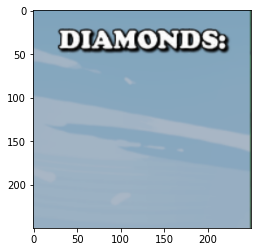

Predicted Reward: 0 Actual Reward: 0


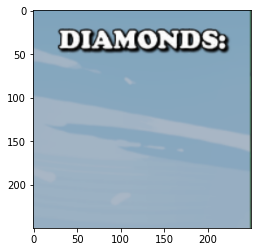

Predicted Reward: 0 Actual Reward: 0


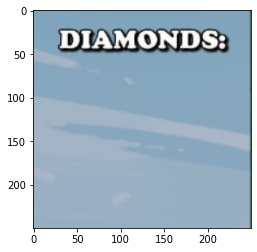

Predicted Reward: 0 Actual Reward: 0


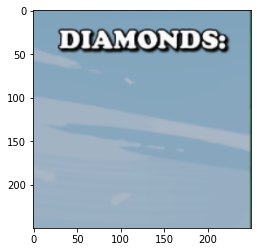

Predicted Reward: 0 Actual Reward: 0


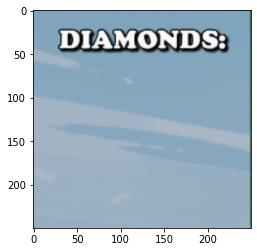

Predicted Reward: 0 Actual Reward: 0


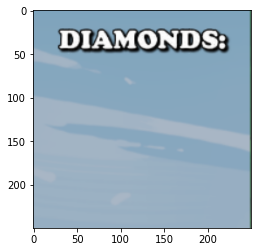

Predicted Reward: 0 Actual Reward: 0


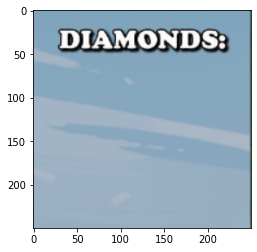

Predicted Reward: 0 Actual Reward: 0


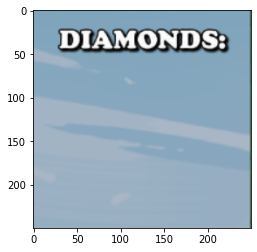

Predicted Reward: 0 Actual Reward: 0


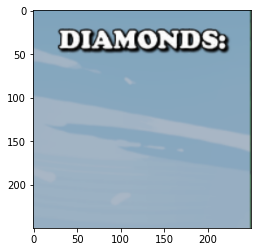

Predicted Reward: 0 Actual Reward: 0


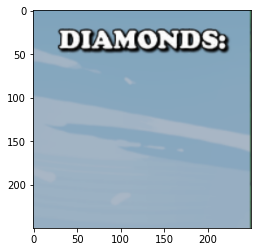

Predicted Reward: 0 Actual Reward: 0


In [26]:
test = torch.load(f'{HUMAN_DATA_PATH}/DM/human_chunk_states{0}.pt')
test = test[:50].to(device)

view_results(test, diamond_labels, diamond_model)

In [35]:
torch.save(lb_model.state_dict(), "D:/Python/Projects/Hakisa/Hakisa/LB_model.pt")

In [22]:
torch.save(score_model.state_dict(), "D:/Python/Projects/Hakisa/Hakisa/SCORE_model.pt")

In [27]:
torch.save(diamond_model.state_dict(), "D:/Python/Projects/Hakisa/Hakisa/DIAMOND_model.pt")